In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eng-to-ar-txt/ara_.txt


In [13]:
import os
import re
import unicodedata

import tensorflow as tf

import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.model_selection import train_test_split

import time
import math

from transformers import AutoTokenizer

In [3]:
data_path = '/kaggle/input/eng-to-ar-txt/ara_.txt'

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
inputs = []
targets = []
num_samples = 10000  # Number of samples to train on.
for line in lines[:- 1]:

    target,input= line.split('\t')
    inputs.append(input)
    targets.append(target)

In [45]:
print(len(inputs),len(targets))
print(inputs[:5])
print(targets[:5])

10742 10742

['مرحبًا.', 'اركض!', 'النجدة!', 'اقفز!', 'قف!']

['Hi.', 'Run!', 'Help!', 'Jump!', 'Stop!']


In [4]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
def replace_phrase(text):
        text = unicode_to_ascii(text.lower().strip())
        text = text.lower()
        text = re.sub(r"there's", "there is", str(text))
        text = re.sub(r"i'm", "i am",  str(text))
        text = re.sub(r"he's", "he is",  str(text))
        text = re.sub(r"she's", "she is",  str(text))
        text = re.sub(r"it's", "it is",  str(text))
        text = re.sub(r"that's", "that is",  str(text))
        text = re.sub(r"what's", "that is",  str(text))
        text = re.sub(r"where's", "where is",  str(text))
        text = re.sub(r"how's", "how is",  str(text))
        text = re.sub(r"\'ll", " will",  str(text))
        text = re.sub(r"\'ve", " have",  str(text))
        text = re.sub(r"\'re", " are",  str(text))
        text = re.sub(r"\'d", " would",  str(text))
        text = re.sub(r"\'re", " are",  str(text))
        text = re.sub(r"won't", "will not",  str(text))
        text = re.sub(r"can't", "cannot",  str(text))
        text = re.sub(r"n't", " not",  str(text))
        text = re.sub(r"n'", "ng",  str(text))
        text = re.sub(r"'bout", "about",  str(text))
        text = re.sub(r"'til", "until",  str(text))
        text = re.sub(r'[" "]+', " ", str(text))
        text = re.sub(r"([?.!,¿])", r" \1 ", text)
        text = re.sub(r"[^a-zA-Z؀-ۿ?.!,¿]+", " ", str(text))
        text = re.sub(r'\b(\w+)\'s\b', r'\1 is', str(text)) #word's => word is
        text = re.sub(r'\b(\w+)\'t\b', r'\1 not', str(text)) #word't => word not
        text = text.strip()
        text = '<start> %s <end>'%text
        
        return text

In [48]:
e='The mobile phone you have dialed is either switched off or outside the coverage area, please try again later.'
a='الهاتف المتحرك الذي طلبته مغلق أو خارج نطاق الخدمة حالياً، يرجى الاتصال لاحقاً.'
print(e)
print()
print(replace_phrase(e))
print('*'*50)
print(a)
print()
print(replace_phrase(a))

The mobile phone you have dialed is either switched off or outside the coverage area, please try again later.



<start> the mobile phone you have dialed is either switched off or outside the coverage area , please try again later . <end>

**************************************************

الهاتف المتحرك الذي طلبته مغلق أو خارج نطاق الخدمة حالياً، يرجى الاتصال لاحقاً.



<start> الهاتف المتحرك الذي طلبته مغلق او خارج نطاق الخدمة حاليا، يرجى الاتصال لاحقا . <end>


In [5]:
pre_inputs = [ replace_phrase(l) for l in inputs]
pre_targets = [ replace_phrase(l) for l in targets]

print(inputs[500])
print(targets[500])


print(pre_inputs[500])
print(pre_targets[500])

أنا مشغول.

I'm not free.

<start> انا مشغول . <end>

<start> i am not free . <end>


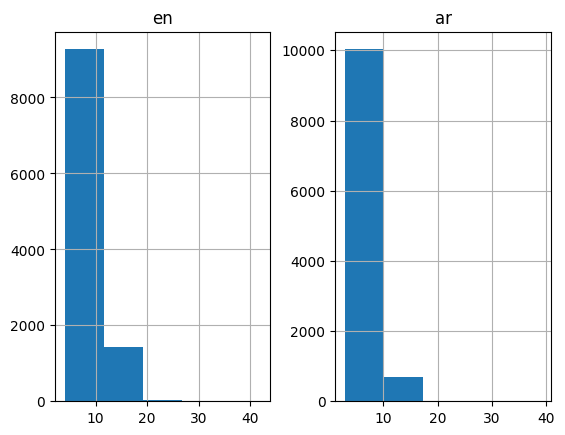

In [50]:
en_count = []
ar_count = []

for sent in pre_inputs:
    ar_count.append(len(sent.split()))
for sent in pre_targets:
    en_count.append(len(sent.split()))

graph_df= pd.DataFrame()
graph_df['en']=en_count
graph_df['ar']=ar_count

import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [6]:
class LanguageIndex():
    
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0

        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [7]:
def max_length(tensor):
    
    return max(len(t) for t in tensor)
def tokniezer():

    inp_lang = LanguageIndex(ar for ar in pre_inputs)
    targ_lang = LanguageIndex(en for en in pre_targets)


    input_tensor = [[inp_lang.word2idx[s] for s in ar.split(' ')] for ar in pre_inputs]

    target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en in pre_targets]

    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)

    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor,
                                                                 maxlen=max_length_inp,
                                                                 padding='post')

    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor,
                                                                  maxlen=max_length_tar,
                                                                  padding='post')

    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [8]:
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = tokniezer()

In [62]:
x="There are mothers and fathers who will lie awake after the children fall asleep and wonder how they'll make the mortgage, or pay their doctor's bills, or save enough for their child's college education."
len(x.split( ))

34

In [63]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(8593, 8593, 2149, 2149)

In [64]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 300
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [65]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 39]), TensorShape([64, 42]))

In [87]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(vocab_inp_size, units, input_length=max_length_inp, mask_zero=True))
model.add(tf.keras.layers.LSTM(units, dropout=0.3, recurrent_dropout=0.3))
model.add(tf.keras.layers.RepeatVector(max_length_targ))
model.add(tf.keras.layers.LSTM(units, return_sequences=True))
model.add(tf.keras.layers.Dense(vocab_tar_size, activation='softmax'))
rms = tf.keras.optimizers.RMSprop(lr=0.001)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.summary()

Model: "sequential_12"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding_8 (Embedding)     (None, 39, 300)           3172800   

                                                                 

 lstm_14 (LSTM)              (None, 300)               721200    

                                                                 

 repeat_vector_7 (RepeatVec  (None, 42, 300)           0         

 tor)                                                            

                                                                 

 lstm_15 (LSTM)              (None, 42, 300)           721200    

                                                                 

 dense_7 (Dense)             (None, 42, 3972)          1195572   

                                                                 


Total params: 5810772 (22.17 MB)

Trainable params: 5810772 (22.17 MB)

Non-trainable params: 0 (0.00 B

In [67]:
target_tensor_train.shape

(8593, 42)

In [88]:
filename = '/kaggle/working/LSTM/LSTM.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(input_tensor_train, target_tensor_train.reshape(target_tensor_train.shape[0], target_tensor_train.shape[1], 1),
                    epochs=10, batch_size=128,callbacks=[checkpoint], validation_data=(input_tensor_val,target_tensor_val),
                    verbose=1)

Epoch 1/10

68/68 [==============================] - ETA: 0s - loss: 2.3106

Epoch 1: val_loss improved from inf to 1.24908, saving model to /kaggle/working/LSTM/LSTM.h5

68/68 [==============================] - 28s 337ms/step - loss: 2.3106 - val_loss: 1.2491

Epoch 2/10


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


68/68 [==============================] - ETA: 0s - loss: 1.1744

Epoch 2: val_loss improved from 1.24908 to 1.11053, saving model to /kaggle/working/LSTM/LSTM.h5

68/68 [==============================] - 16s 239ms/step - loss: 1.1744 - val_loss: 1.1105

Epoch 3/10

68/68 [==============================] - ETA: 0s - loss: 1.0837

Epoch 3: val_loss did not improve from 1.11053

68/68 [==============================] - 14s 200ms/step - loss: 1.0837 - val_loss: 1.1238

Epoch 4/10

68/68 [==============================] - ETA: 0s - loss: 1.0344

Epoch 4: val_loss improved from 1.11053 to 1.01871, saving model to /kaggle/working/LSTM/LSTM.h5

68/68 [==============================] - 14s 200ms/step - loss: 1.0344 - val_loss: 1.0187

Epoch 5/10

68/68 [==============================] - ETA: 0s - loss: 0.9905

Epoch 5: val_loss improved from 1.01871 to 1.00380, saving model to /kaggle/working/LSTM/LSTM.h5

68/68 [==============================] - 13s 195ms/step - loss: 0.9905 - val_loss: 1.0038

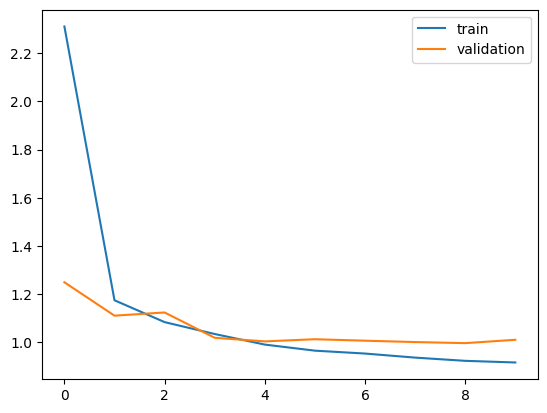

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [95]:
model = tf.keras.models.load_model('/kaggle/working/LSTM/LSTM.h5')
preds = model.predict(input_tensor_val.reshape((input_tensor_val.shape[0],input_tensor_val.shape[1])))

68/68 [==============================] - 2s 17ms/step


In [108]:
def get_word(n):
    for index,word in inp_lang.word2idx.items():
        if index == n:
            return word
    return None

In [112]:
def gru(units):

    return tf.keras.layers.GRU(units,
                                return_sequences=True,
                                return_state=True,
                                recurrent_activation='sigmoid',
                                recurrent_initializer='glorot_uniform')

In [113]:
class Encoder(tf.keras.Model):
   
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [114]:
class Decoder(tf.keras.Model):
    ''' Create the decoder, also needs to have access to the source information.

    This class create decoder which consists of decoder_cell (similar to encoder_cell),
    a helper, and the previous encoder_state as inputs.

    Attributes:
        vocab_size: Size of vocabulary
        embedding_dim: Embedding vector length
        enc_units:  Number of GRUs units
        batch_sz: batch size ** minimize it for low RAM
    '''
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)

        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)

        return x, state, attention_weights

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

    def saved_hidden_state(self):
        return self.gru.states

In [115]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [116]:
optimizer = tf.keras.optimizers.Adam()


def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [117]:
checkpoint_dir = '/kaggle/working/'
checkpoint_prefix = os.path.join(checkpoint_dir, "h5")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [118]:
from tqdm import tqdm 
EPOCHS = 10
best_total_loss = 0.0

for epoch in tqdm(range(EPOCHS)):
    start = time.time()

    hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0

        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)

            dec_hidden = enc_hidden

            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)

            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

                loss += loss_function(targ[:, t], predictions)

                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))

        total_loss += batch_loss

        variables = encoder.variables + decoder.variables

        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / N_BATCH))

    if best_total_loss > (total_loss / N_BATCH):

        best_total_loss = total_loss

        encoder.save_weights(encoder_prefix)
        decoder.save_weights(decoder_prefix)

        print('Saving weights at epoch {} with Loss {:.4f}'.format(epoch + 1, total_loss / N_BATCH))
        
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 1.5725

Epoch 1 Batch 100 Loss 0.9340


 10%|█         | 1/10 [02:56<26:26, 176.29s/it]

Epoch 1 Loss 1.0263

Time taken for 1 epoch 176.28580617904663 sec



Epoch 2 Batch 0 Loss 0.9460

Epoch 2 Batch 100 Loss 0.8604


 20%|██        | 2/10 [05:30<21:48, 163.56s/it]

Epoch 2 Loss 0.8628

Time taken for 1 epoch 154.64561128616333 sec



Epoch 3 Batch 0 Loss 0.7844

Epoch 3 Batch 100 Loss 0.7574


 30%|███       | 3/10 [08:00<18:21, 157.32s/it]

Epoch 3 Loss 0.8011

Time taken for 1 epoch 149.88608407974243 sec



Epoch 4 Batch 0 Loss 0.7730

Epoch 4 Batch 100 Loss 0.7496


 40%|████      | 4/10 [10:29<15:22, 153.75s/it]

Epoch 4 Loss 0.7472

Time taken for 1 epoch 148.27415013313293 sec



Epoch 5 Batch 0 Loss 0.7522

Epoch 5 Batch 100 Loss 0.7022


 50%|█████     | 5/10 [12:57<12:39, 151.97s/it]

Epoch 5 Loss 0.7003

Time taken for 1 epoch 148.82988452911377 sec



Epoch 6 Batch 0 Loss 0.7341

Epoch 6 Batch 100 Loss 0.7124


 60%|██████    | 6/10 [15:28<10:05, 151.43s/it]

Epoch 6 Loss 0.6607

Time taken for 1 epoch 150.38314604759216 sec



Epoch 7 Batch 0 Loss 0.6478

Epoch 7 Batch 100 Loss 0.6313


 70%|███████   | 7/10 [18:00<07:34, 151.66s/it]

Epoch 7 Loss 0.6279

Time taken for 1 epoch 152.1210606098175 sec



Epoch 8 Batch 0 Loss 0.6174

Epoch 8 Batch 100 Loss 0.5516


 80%|████████  | 8/10 [20:33<05:04, 152.18s/it]

Epoch 8 Loss 0.5998

Time taken for 1 epoch 153.3083462715149 sec



Epoch 9 Batch 0 Loss 0.5774

Epoch 9 Batch 100 Loss 0.5647


 90%|█████████ | 9/10 [23:06<02:32, 152.37s/it]

Epoch 9 Loss 0.5746

Time taken for 1 epoch 152.78016781806946 sec



Epoch 10 Batch 0 Loss 0.5887

Epoch 10 Batch 100 Loss 0.5792


100%|██████████| 10/10 [25:39<00:00, 153.98s/it]

Epoch 10 Loss 0.5493

Time taken for 1 epoch 153.28688526153564 sec




In [119]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = replace_phrase(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [120]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)

    heatmap = ax.matshow(attention, cmap='rainbow')

    for y in range(attention.shape[0]):
        for x in range(attention.shape[1]):
            ax.text(x , y, '%.4f' % attention[y, x],
                     horizontalalignment='center',
                     verticalalignment='center', color='black')

    fig.colorbar(heatmap)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [121]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> اريد افضل من ذلك <end>

Predicted translation: i want to do . <end> 


/tmp/ipykernel_42/955416664.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator

  ax.set_xticklabels([''] + sentence, fontdict=fontdict)

/tmp/ipykernel_42/955416664.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator

  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


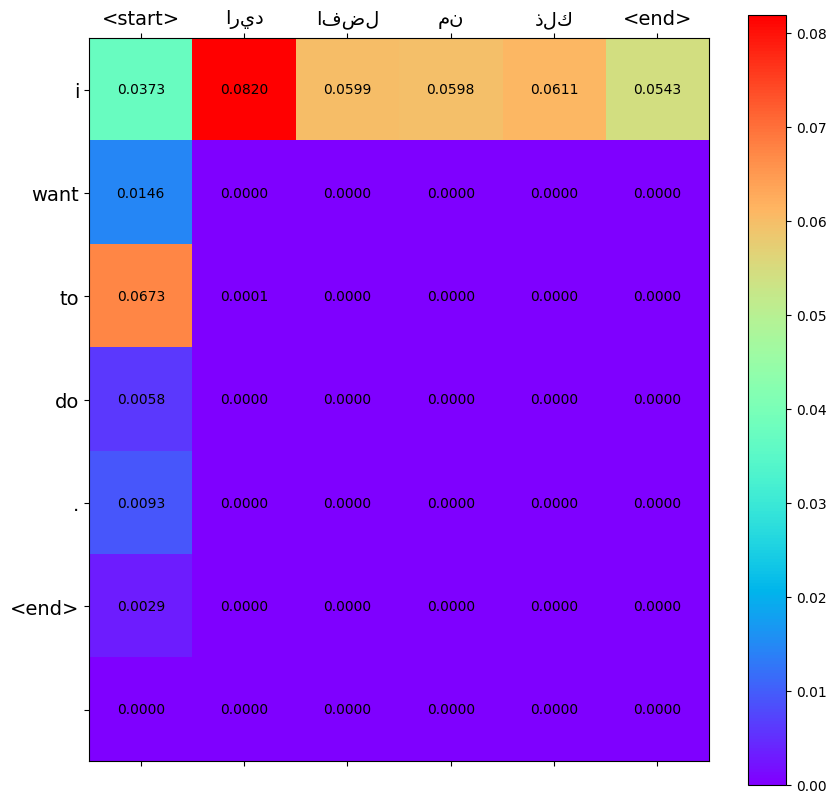

In [123]:
translate(u'اريد افضل من ذلك', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)